<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model interpretation using Kernel SHAP (SHapley Additive exPlanations) for  terrestrial water-energy-carbon fluxes

This notebook shows how to apply the Kernel SHAP explainability method on a model trained to predict "**latent heat flux (LEtot)**". The model is a Random Forest model that predicts "LEtot" using a set ofland-atmosphere variables.<br>

The model training workflow and data are based on the research carried by "Qianqian Han" https://doi.org/10.5194/egusphere-egu24-5488 in the context of [EcoExtreML](https://research-software-directory.org/projects/ecoextreml) project. 

Kernel SHAP (SHapley Additive exPlanations) values are a unified measure of feature importance that allocates the contribution of each feature to the prediction for a specific instance. In the context of a regression problem, the interpretation of Kernel SHAP values is as follows:

- **Magnitude**: The magnitude of a SHAP value for a feature indicates the degree to which that feature affects the prediction. A larger absolute SHAP value means that the feature has a stronger impact on the output.
- **Sign**: The sign of a SHAP value indicates the direction of the effect. A positive SHAP value for a feature indicates that the presence of that feature increases the model's output, while a negative SHAP value indicates that the presence of that feature decreases the model's output.
- **Zero**: A SHAP value of zero for a feature indicates that the feature did not contribute to the prediction for that specific instance.

It's important to note that SHAP values are instance-specific. For a general measure of feature importance, you would need to calculate SHAP values for many instances and then aggregate them in some way.

#### Colab Setup

In [ ]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 - Libraries

In [46]:
import pandas as pd
import numpy as np
from joblib import load
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import dianna
from dianna import visualization
from dianna.utils import SimpleModelRunner
from dianna.utils.downloader import download

np.random.seed(0)

#### 1- Load and visualize the data

In [40]:
data_path = download('stemmus_scope_emulator_train_test_2014_data.csv', 'data')
model_input = pd.read_csv(data_path)
model_input

,Unnamed: 0,station,date_UTC,Precip_msr,Rin,Rli,p,Ta,ea,u,...,IGBP_veg_long2,IGBP_veg_long3,IGBP_veg_long4,IGBP_veg_long5,IGBP_veg_long6,IGBP_veg_long7,IGBP_veg_long8,IGBP_veg_long9,IGBP_veg_long10,IGBP_veg_long11
0,0,AU-ASM,2013-12-31 15:00:00,0.0,0.000000,422.350995,940.534220,31.677529,0.087688,2.134386,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AU-ASM,2013-12-31 16:00:00,0.0,0.000000,405.639800,932.560705,31.299402,0.099312,1.201066,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AU-ASM,2013-12-31 17:00:00,0.0,0.000000,413.726000,939.196055,30.007821,0.107478,1.354100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AU-ASM,2013-12-31 18:00:00,0.0,0.000000,412.545700,940.048085,30.011499,0.110519,1.795051,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AU-ASM,2013-12-31 19:00:00,0.0,0.000000,381.210585,940.882070,29.375940,0.112046,1.729858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136583,136583,US-Myb,2014-03-14 22:00:00,0.0,691.839510,315.739010,1023.000000,20.380014,10.184294,2.369500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136584,136584,US-Myb,2014-03-14 23:00:00,0.0,536.578495,315.739010,1022.500000,21.415002,10.509555,1.799000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136585,136585,US-Myb,2014-03-15 00:00:00,0.0,346.486005,309.051010,1022.200000,22.374994,10.878103,1.528500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136586,136586,US-Myb,2014-03-15 01:00:00,0.0,150.326500,302.363010,1022.150000,22.409997,10.705077,1.653500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
# test, train data
x_vars = ['station', 'date_UTC', 'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = model_input[x_vars]

y_vars = ['station', 'date_UTC', 'LEtot']
y = model_input[y_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)

#### 2- Load the model

In [27]:
def preprocess(data):
    data_reshaped = data
    if len(data.shape) == 1:
        data_reshaped = data.reshape(1,-1)
    return data_reshaped.astype(np.float32)

model_path = download('stemmus_scope_emulator_model_LEtot.onnx', 'model')
runner = SimpleModelRunner(model_path, preprocess_function=preprocess)

#### 3 - Run the explainer

In [24]:
# select one instance of test data
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0)
data_instance = features.iloc[0].values.reshape(1, -1)
background_data = np.zeros(data_instance.shape)  # it should be `x_train` but it is slower

In [ ]:
%%time
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                     feature_names=features.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1.8 s, sys: 63.3 ms, total: 1.86 s
Wall time: 1.05 s


#### 4 - Visualize the results

In [ ]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

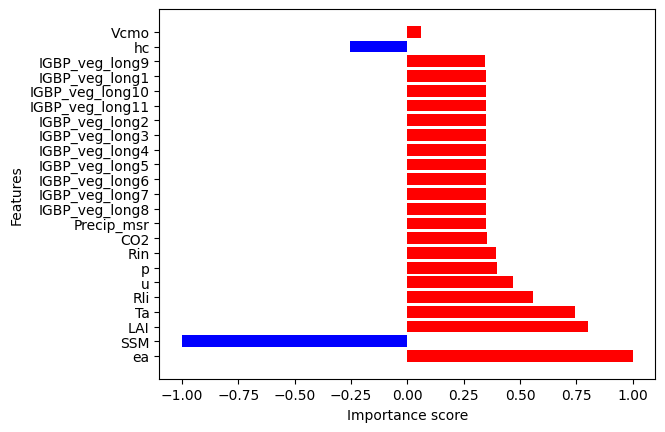

In [32]:
heat_map = normalize(explanation)[0]
_ = visualization.plot_tabular(heat_map, features.columns, num_features=len(features.columns))

#### 5 -  Run the explainer at one location

In [35]:
# select one location
x_test_time = x_test[x_test["station"] == "US-Myb"]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)

# loop overtime series
explanations = np.zeros(features.shape)
for time in range(features.shape[0]):
    data_instance = features.iloc[time].values.reshape(1, -1)
    background_data = np.zeros(data_instance.shape)
    explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                    feature_names=features.columns, silent=True)
    explanations[time] = normalize(explanation)

print("Dianna is done!") 

Dianna is done!


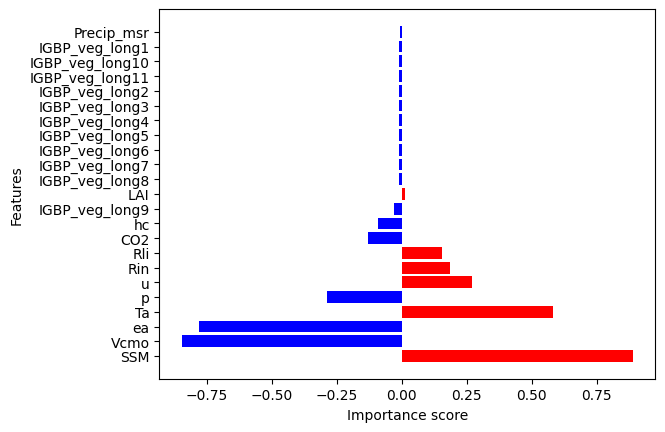

In [36]:
heat_map = explanations.mean(axis=0) 
_ = visualization.plot_tabular(heat_map, features.columns, num_features=len(features.columns))

In [ ]:
# plot predictions vs test data at one location
y_predict_time = runner(features)
y_test_time = y_test[y_test["station"] == "US-Myb"].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_predict_time, label='Prediction')
plt.plot(y_test_time, label='Test data')

plt.xlabel('time index')
plt.ylabel('LEtot')
plt.legend()

plt.show()

In [ ]:
# calculate MAE
np.mean(np.abs(y_predict_time - y_test_time))

#### 6 -  Run the explainer at one time

In [88]:
# select one time
x_test_space = x_test[x_test["date_UTC"] == "2014-04-28 09:00:00"]
features = x_test_space.drop(columns=['station', 'date_UTC']).fillna(0)

# loop overall loations
explanations = np.zeros(features.shape)
for location in range(features.shape[0]):
    data_instance = features.iloc[location].values.reshape(1, -1)
    background_data = np.zeros(data_instance.shape)
    explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                    feature_names=features.columns, silent=True)
    explanations[location] = normalize(explanation)

print("Dianna is done!") 

Dianna is done!


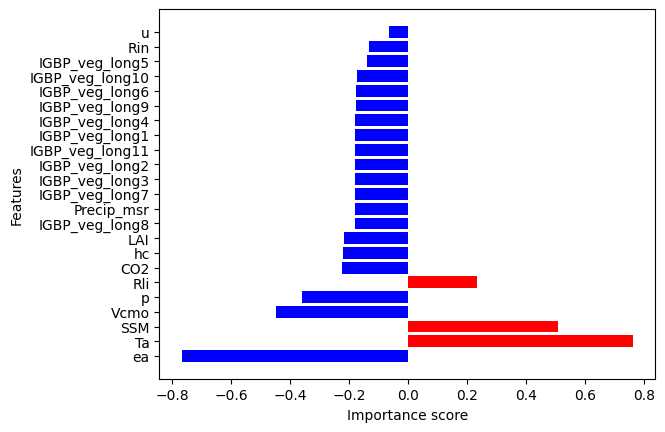

In [89]:
heat_map = explanations.mean(axis=0)
_ = visualization.plot_tabular(heat_map, features.columns, num_features=len(features.columns))

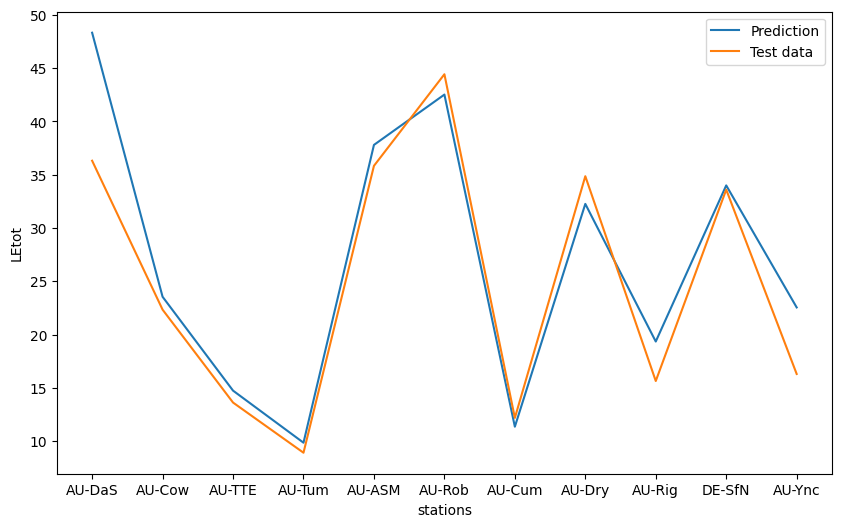

In [115]:
# plot predictions vs test data at one location
y_predict_space = runner(features)
y_test_space = y_test[y_test["date_UTC"] == "2014-04-28 09:00:00"].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_test_space["station"], y_predict_space, label='Prediction')
plt.plot(y_test_space, label='Test data')

plt.xlabel('stations')
plt.ylabel('LEtot')
plt.legend()

plt.show()